### Imports

In [1]:
from __future__ import division, print_function

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
import re
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


### path and batch size

In [2]:
path = "data"
batch_size = 64
# path = "data/sample"
# batch_size = 4

### 1. read in batches for training and validation

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


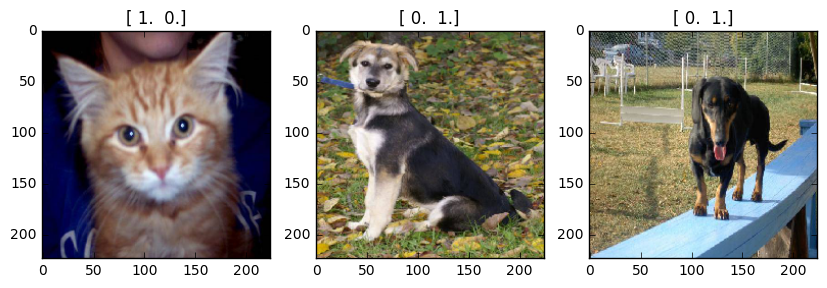

In [3]:
generator = ImageDataGenerator()
train_batches = generator.flow_from_directory(directory=path+"/train",
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

valid_batches = generator.flow_from_directory(directory=path+"/valid",
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

imgs, lbls = next(train_batches)
plt_imgs = imgs[0:3]
f, axes = plt.subplots(1, 3, figsize=(10, 6)) #fig size in width, height (inches)
for i in range(len(plt_imgs)):
    # imshow needs unsigned 8 bit ints for vals
    # imshow also needs axes as (width, height, channel), ours come in the other way
    img = plt_imgs[i].astype(np.uint8).transpose((1,2,0))
    label = lbls[i]
    axes[i].imshow(img)
    axes[i].set_title(label)

This looks pretty good, we are loading in the images, they all seem to be the right size, and they are certainly mixed together well, so shuffle is working

### 2. generate model and load weights
We can find info on the VGG architecture both [here](https://arxiv.org/pdf/1409.1556.pdf) and in the _vgg.py_ file. Essentially , the model can be looked at as:
    1. C1 - 2 * conv3 layer, n=64, relu activation, zero-padding 1, maxpool - half
    2. C2 - 2 * conv3 layer, n=128, relu activation, zero-padding 1, maxpool - half
    3. C3 - 3 * conv3 layer, n=256, relu activation, zero-padding 1, maxpool - half
    4. C4 - 3 * conv3 layer, n=512, relu activation, zero-padding 1, maxpool - half
    5. C5 - 3 * conv3 layer, n=512, relu activation, zero-padding 1, maxpool - half
    6. Flatten
    7. F1 - 1 * FC layer, size 4096, relu activation, Dropout 0.5
    8. F2 - 1 * FC layer, size 4096, relu activation, Droput 0.5
    9. O1 - 1 * FC layer, size 1000, softmax activation
    
These blocks contain the 16 vgg layers (2+2+3+3+3+1+1+1 = 16) in two kinds of blocks. Lets write some code for each of these blocks in keras and then stick them together to make our model.

There are a few tricks:
* the VGG model switches its channels from R,G,B to B,G,R and expects mean-normalized data. We will need to preprocess the data to do this before we can pipe it through. We can do this using the Lambda function provided by Keras.
* the weights are stored on the course server, we will need to go grab them and pre-load before we can finetune.

In [3]:
def Conv(model, n_layers, n_filts):
    for layer in range(n_layers):
        model.add(ZeroPadding2D((1,1))) # our data is 2D, takes a tuple for rows, cols
        model.add(Convolution2D(n_filts, 3, 3, activation='relu'))
    # 2 * 2 max pooling with equal strides will halve each dim
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2))) 
    return model

def FC(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    return model

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1)) # need to reshape for mat.sub.
def preprocess(data):
    data = data - vgg_mean # sub mean
    data = data[:, ::-1] # reverse channels
    return data
       
def VGG():
    model = Sequential() # basic multi-layer model in Keras. layers are in order
    # want to ensure our input and output are is correct
    model.add(Lambda(preprocess, output_shape=(3,224,224), input_shape=(3,224,224))) 
    Conv(model, 2, 64)
    Conv(model, 2, 128)
    Conv(model, 3, 256)
    Conv(model, 3, 512)
    Conv(model, 3, 512)
    model.add(Flatten())
    FC(model)
    FC(model)
    model.add(Dense(1000, activation='softmax'))
    # note we are using a "models" subdirectory in our current directory as the cache
    model.load_weights(get_file('vgg16.h5' ,'http://www.platform.ai/models/vgg16.h5', cache_subdir='models'))
    return model
  
vgg = VGG()

Great! We've now loaded a Keras model of VGG!

In [38]:
vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 224, 224)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_27[0][0]           
___________________________________________________________________________________________

## 3. Replace last two/three layers and train
First, lets remove the layers we don't want. We are going to leave the convolutional layers alone, and remove all of the fully connected pieces afterwards.

In [52]:
vgg.pop() # last dense
vgg.pop() # last dropout
vgg.pop() # middle dense
vgg.pop() # middle dropout
vgg.pop() # first dense dense
vgg.pop() # flatten
vgg.pop() # max pooling
for layer in vgg.layers:
    layer.trainable = False # want to freeze all remaining layers
vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_40 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_40[0][0]           
____________________________________________________________________________________________________
zeropadding2d_41 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_40[0][0]           
___________________________________________________________________________________________

#### pre-compute
Now, for experimental purposes, lets pre-compute the output of the experimental part and save it so that we can quickly mess with the fine-tuning parameters afterwards

In [ ]:
# gotta get a new non-shuffled input!
batches = generator.flow_from_directory(directory=path+"/train",
                                        target_size=(224, 224),
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False)
# gotta get a new non-shuffled input!
val_batches = generator.flow_from_directory(path+'/valid',
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

val_classes = val_batches.classes # will need to pass these in
trn_classes = batches.classes # will need to pass these in
val_labels = to_categorical(val_classes) # will need to pass these in
trn_labels = to_categorical(trn_classes) # will need to pass these in

train_preds = vgg.predict_generator(batches, batches.nb_sample)
valid_preds = vgg.predict_generator(val_batches, val_batches.nb_sample)

#### experimental model
Now lets define our experimental dense model based on the VGG architecture and try it out

In [4]:
def exp_model(p):
    model = Sequential() # basic multi-layer model in Keras. layers are in order
    model.add(MaxPooling2D(input_shape=(512, 14, 14), pool_size=(2, 2), strides=(2,2))) 
    model.add(Flatten())
    model.add(Dense(4096, activation='relu')) # we are retraining this layer
    model.add(Dropout(p))
    model.add(BatchNormalization()) # we are going to try batch normalizing, since its usually a good idea
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(p))
    model.add(BatchNormalization()) # batch normalize after every layer
    model.add(Dense(2, activation='softmax')) # we are retraining our output to map to TWO classes
    # need to compile the model before training, here we pass in our loss and opt funcs, as well as metrics
    model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    return model

exp = exp_model(0.5) # tried no dropout, tried  0.4, 0.5, 0.7, 0.9

looks good! lets try training now. Its a good Idea to start with one epoch at the default rate to get the learning set up, before increasing it by quite a bit. The epoch times for this should be much slower since we are only training a few dense layers.

In [ ]:
# note here we use fit to work from a a static set, using our conv layers output as input.
exp.fit(train_preds, trn_labels, batch_size=batch_size,
        validation_data=(valid_preds, val_labels),
        nb_epoch=1)

See, we can now train an epoch in about 40s, which allows us to experiment much faster. With one default epoch under our belts, lets try a few at a higher rate.

In [ ]:
exp.optimizer.lr = 0.0001
exp.fit(train_preds, trn_labels, batch_size=batch_size,
        validation_data=(valid_preds, val_labels),
        nb_epoch=1)

we go until it is about to overfit, the adjust the rate back down by an order of magnitude or two...

In [ ]:
exp.optimizer.lr = 0.0001
exp.fit(train_preds, trn_labels, batch_size=batch_size,
        validation_data=(valid_preds, val_labels),
        nb_epoch=1) # seems to overfit at 3 epochs

now that we are happy with this, lets save these weights

In [ ]:
exp.save_weights('models/fc2.h5')

#### rebuild the full model
Now that we are happy with the overall training and layers as a result of our experiment, lets rebuild the full model and train.

In [ ]:
exp.load_weights('models/fc2.h5')

In [54]:
# we already set our vgg layers to be non-trainable. 
# NOTE all copied layers copy their weights too! be careful of overtraining with this!
# NOTE if we didnt have to replace the one layer, we could just add the two models together directly with .add()
vgg.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2))) # need to add first max pooling without input
    
for layer in exp.layers[1:]: 
    vgg.add(layer)
vgg.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']) 
vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_40 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_40[0][0]           
____________________________________________________________________________________________________
zeropadding2d_41 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_40[0][0]           
___________________________________________________________________________________________

#### add image augmentation to reduce overfitting

In [7]:
# NOTE: We don't want to augment or shuffle the validation set

gen = ImageDataGenerator(rotation_range=15, 
                         width_shift_range=0.15, 
                         height_shift_range=0.15,
                         shear_range=0.0225,
                         zoom_range=0.15, 
                         channel_shift_range=15.,
                         horizontal_flip=True)

train_batches = gen.flow_from_directory(directory=path+"/train",
                                        target_size=(224, 224),
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=True)

NameError: name 'path' is not defined

#### train to finetune

In [56]:
vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                  validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                  nb_epoch=2)

Epoch 1/2
23000/23000 [==============================] - 639s - loss: 0.2077 - acc: 0.9468 - val_loss: 0.1405 - val_acc: 0.9660
Epoch 2/2
23000/23000 [==============================] - 639s - loss: 0.0909 - acc: 0.9685 - val_loss: 0.0612 - val_acc: 0.9855


In [58]:
# very very very low learning rate, just want to "touch up" here
vgg.optimizer.lr = 0.001
vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                  validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                  nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 640s - loss: 0.0799 - acc: 0.9727 - val_loss: 0.0692 - val_acc: 0.9770


In [59]:
# very very very low learning rate, just want to "touch up" here
vgg.optimizer.lr = 0.00001
vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                  validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                  nb_epoch=2)

Epoch 1/2
23000/23000 [==============================] - 637s - loss: 0.0735 - acc: 0.9737 - val_loss: 0.0580 - val_acc: 0.9855
Epoch 2/2
23000/23000 [==============================] - 640s - loss: 0.0698 - acc: 0.9769 - val_loss: 0.0545 - val_acc: 0.9840


In [61]:
# very very very low learning rate, just want to "touch up" here
vgg.optimizer.lr = 0.0000001
vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                  validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                  nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 639s - loss: 0.0645 - acc: 0.9785 - val_loss: 0.0900 - val_acc: 0.9810


In [62]:
# very very very low learning rate, just want to "touch up" here
vgg.optimizer.lr = 0.000000001
vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                  validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                  nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 641s - loss: 0.0637 - acc: 0.9783 - val_loss: 0.1662 - val_acc: 0.9785


In [63]:
# very very very low learning rate, just want to "touch up" here
vgg.optimizer.lr = 0.000000001
vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                  validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                  nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 639s - loss: 0.0602 - acc: 0.9799 - val_loss: 0.1924 - val_acc: 0.9750


In [ ]:
# very very very low learning rate, just want to "touch up" here
vgg.optimizer.lr = 0.000000001
vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                  validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                  nb_epoch=1)

In [60]:
vgg.save_weights('models/ft10.h5')

### 4. Format Output

In [49]:
vgg.load_weights('models/ft9.h5')

In [50]:
# setting shuffle=False here is VERY important for file ordering. Score will be TERRIBLE otherwise
test_batches = generator.flow_from_directory(directory=path+"/test",
                                             target_size=(224, 224),
                                             batch_size=batch_size*2,
                                             class_mode='categorical',
                                             shuffle=False)

# get names
filepaths = test_batches.filenames
filenames = []
for name in filepaths:
    filenames.append(int(re.findall("(\d{1,6})", name)[0]))

# get predictions
preds = vgg.predict_generator(test_batches, val_samples=12500)
dog_scores = preds[:, 1]    
dog_scores = dog_scores.clip(min=0.01, max=0.99)

filenames = pd.Series(filenames, name='id')
scores = pd.Series(dog_scores, name='label')
submission = pd.concat([filenames, scores], axis=1).sort_values('id', ascending=True)
submission.to_csv('submission_fc_redo.csv', index=False)
submission.head(5)

Found 12500 images belonging to 1 classes.


,id,label
7082,1,0.99
4067,2,0.99
3558,3,0.99
5730,4,0.99
2852,5,0.01


## 4. Ensemble

Here, I switched to using the ADAM() optimizer, which seems to work better, and with LESS learning rate tinkering (not totally true).

The function trains a model with best params, Here I trained a bunch and then averaged them

In [ ]:
from keras.optimizers import Adam

def fit_train_pred_vgg(train_batches, valid_batches, test_batches, model_name):
    print(model_name)
    # set up model
    vgg = VGG()
    vgg.pop() # last dense
    vgg.pop() # last dropout
    vgg.pop() # middle dense
    vgg.pop() # middle dropout
    vgg.pop() # first dense dense
    vgg.pop() # flatten
    vgg.pop() # max pooling
    for layer in vgg.layers:
        layer.trainable = False # want to freeze all remaining layers
    exp = exp_model(0.6)
    vgg.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2))) # need to add first max pooling without input
    for layer in exp.layers[1:]: 
        vgg.add(layer)
    vgg.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    # set up data - NOTE, this is IMPORTANT,  generators
    # do not reset properly if outside the function and used multiple times!!!
    generator = ImageDataGenerator()
    gen = ImageDataGenerator(rotation_range=10, 
                             width_shift_range=0.1, 
                             height_shift_range=0.1,
                             shear_range=0.15,
                             zoom_range=0.1, 
                             channel_shift_range=10.,
                             horizontal_flip=True)
    train_batches = gen.flow_from_directory(directory=path+"/train",
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=True)
    test_batches = generator.flow_from_directory(directory=path+"/test",
                                                 target_size=(224, 224),
                                                 batch_size=batch_size*2,
                                                 class_mode='categorical',
                                                 shuffle=False)
    valid_batches = generator.flow_from_directory(directory=path+"/valid",
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)
    # train model
    vgg.optimizer.lr=1e-5
    vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                      validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                      nb_epoch=3)
    vgg.optimizer.lr=1e-6
    vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                      validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                      nb_epoch=2)
    vgg.optimizer.lr=1e-7
    vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                      validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                      nb_epoch=2)
    vgg.optimizer.lr=1e-8
    vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                      validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                      nb_epoch=2)
    vgg.optimizer.lr=1e-9
    vgg.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                      validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample,
                      nb_epoch=2)
    vgg.save_weights('models/' + model_name + '.h5')
    print("done fit")
    # get names
    filepaths = test_batches.filenames
    filenames = []
    for name in filepaths:
        filenames.append(int(re.findall("(\d{1,6})", name)[0]))

    # get predictions
    preds = vgg.predict_generator(test_batches, val_samples=12500)
    dog_scores = preds[:, 1]    
    dog_scores = dog_scores.clip(min=0.01, max=0.99)

    filenames = pd.Series(filenames, name='id')
    scores = pd.Series(dog_scores, name='label')
    submission = pd.concat([filenames, scores], axis=1).sort_values('id', ascending=True)
    submission.to_csv('predictions/' + model_name + '.csv', index=False)
    return submission

scores1 = fit_train_pred_vgg(train_batches, valid_batches, test_batches, 'one')
scores2 = fit_train_pred_vgg(train_batches, valid_batches, test_batches, 'two')
scores3 = fit_train_pred_vgg(train_batches, valid_batches, test_batches, 'three')
scores4 = fit_train_pred_vgg(train_batches, valid_batches, test_batches, 'four')
scores5 = fit_train_pred_vgg(train_batches, valid_batches, test_batches, 'five')
scores6 = fit_train_pred_vgg(train_batches, valid_batches, test_batches, 'six')
scores7 = fit_train_pred_vgg(train_batches, valid_batches, test_batches, 'seven')
scores8 = fit_train_pred_vgg(train_batches, valid_batches, test_batches, 'eight')
scores9 = fit_train_pred_vgg(train_batches, valid_batches, test_batches, 'nine')
scores10 = fit_train_pred_vgg(train_batches, valid_batches, test_batches, 'ten')

one
Found 23000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/3
23000/23000 [==============================] - 683s - loss: 0.2292 - acc: 0.9012 - val_loss: 0.0547 - val_acc: 0.9800
Epoch 2/3
23000/23000 [==============================] - 685s - loss: 0.1047 - acc: 0.9596 - val_loss: 0.0475 - val_acc: 0.9815
Epoch 3/3
23000/23000 [==============================] - 685s - loss: 0.0853 - acc: 0.9672 - val_loss: 0.0455 - val_acc: 0.9850
Epoch 1/2
23000/23000 [==============================] - 683s - loss: 0.0797 - acc: 0.9703 - val_loss: 0.0461 - val_acc: 0.9855
Epoch 2/2
23000/23000 [==============================] - 682s - loss: 0.0700 - acc: 0.9733 - val_loss: 0.0444 - val_acc: 0.9850
Epoch 1/2
23000/23000 [==============================] - 683s - loss: 0.0690 - acc: 0.9739 - val_loss: 0.0449 - val_acc: 0.9855
Epoch 2/2
23000/23000 [==============================] - 683s - loss: 0.0643 - acc: 0.9759 - val_los

In [28]:
import pandas as pd
# scores1 = pd.read_csv('predictions/one.csv')
# scores2 = pd.read_csv('predictions/two.csv')
# scores3 = pd.read_csv('predictions/three.csv')
# scores4 = pd.read_csv('predictions/four.csv')
# scores5 = pd.read_csv('predictions/five.csv')
# scores6 = pd.read_csv('predictions/six.csv')
all_scores = pd.concat([scores1, scores2, scores3, scores4, scores5, scores6,
                        scores7, scores8, scores9, scores10], axis=0)
means = all_scores.groupby('id').mean().reset_index()

In [29]:
means.head(5)

,id,label
0,1,0.99
1,2,0.99
2,3,0.99
3,4,0.99
4,5,0.01


In [30]:
means.to_csv('predictions/submission_means10_fullfit.csv', index=False)